In [651]:
# Manually rotated and found the issue

In [652]:
%matplotlib inline

import imutils
import sys
import os
import numpy as np
import cv2
import copy
import math as mt
from math import sin, cos, radians, pi
from scipy.signal import find_peaks
from sympy import Point, Line, Symbol, pi
from skimage import draw
import matplotlib.pyplot as plt
import time
import math
from statistics import mode
import pandas as pd
from natsort import natsorted
from statistics import median

In [653]:
sys.path.insert(0, '/media/Work/Codes/Private/pdf417-decoder/code/python/new/src')
from barcode_detector import BarcodeDetector

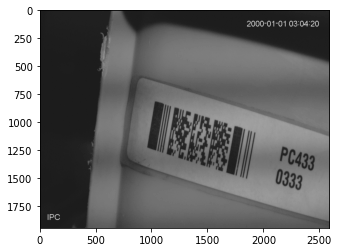

In [654]:
MODEL_PATH = '/media/Work/Codes/Private/pdf417-decoder/code/python/new/src/pdf417_model/PDF417_frozen_inference_graph_Gray_v1.pb'
# INPUT_PATH = 'in/IP_TVS_2020_04_21_00014.png'
INPUT_PATH = '/home/sandana/Pictures/03.jpeg'
# INPUT_PATH = 'in/IP_TVS_2020_04_21_00009_00016.png'
DETECTOR_OUTPUT_PATH = '/media/Work/Codes/Private/pdf417-decoder/code/python/new/out/Detection_Output.bmp'
CROP_PATH = '/media/Work/Codes/Private/pdf417-decoder/code/python/new/src/out/Crop_Output.bmp'
BIN_OUTPUT_PATH = '/media/Work/Codes/Private/pdf417-decoder/code/python/new/out/Bin_Output.bmp'

bd = BarcodeDetector(MODEL_PATH, 'GRAY')
image = cv2.imread(INPUT_PATH, 0)
plt.imshow(image, cmap='gray')

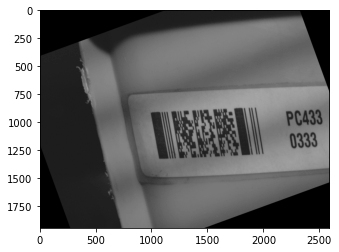

In [655]:
rotated_image = imutils.rotate(image, 20)
plt.imshow(rotated_image, cmap='gray')

In [656]:
image = rotated_image

In [657]:
# custom_pdf417_decoder = custom_PDF417()
print(image.shape)

boxes = bd.predict(image)
detected_image = copy.deepcopy(image)
#
#
print(f'boxes: {boxes}')

def put_rectangle(img, bbox):
    return cv2.rectangle(img, (bbox[1], bbox[0]),
                         (bbox[3], bbox[2]), (0, 255, 0), 5)
#
#
for box in boxes:
    x1, y1, x2, y2 = list(map(int, box))
    new_image = image[x1:x2, y1:y2]
    cv2.imwrite(CROP_PATH, new_image)
    put_rectangle(detected_image, box)

(1944, 2592)
boxes: [[ 831  919 1405 2051]]


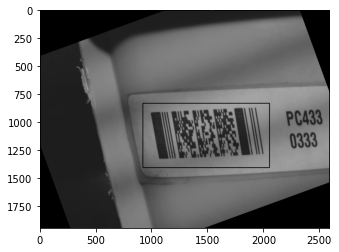

In [658]:
plt.imshow(detected_image, cmap='gray')

In [659]:
THRESHOLD = 0.25

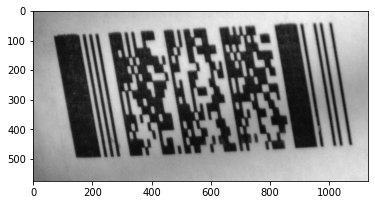

In [660]:
input_image = new_image
plt.imshow(input_image, cmap='gray')

In [661]:
# # INPUT_IMAGE_PATH = '/media/Work/Codes/Private/pdf417-decoder/output/images/'\
# #                    'Crop/15-02-2021/17:00:00/15-02-2021_17:42:57:272_009/00031_1.bmp'

# INPUT_IMAGE_PATH = '/media/Work/Codes/Private/pdf417-decoder/code/python/new/src/out/Crop_Output.png'
# # INPUT_PATH = '/home/sandana/Documents/good_crops'
# # image_files = natsorted(os.listdir(INPUT_PATH))

# # INPUT_IMAGE_PATH = os.path.join(INPUT_PATH, image_files[10])
# print(f'INPUT_IMAGE_PATH: {INPUT_IMAGE_PATH}')
# input_image = cv2.imread(INPUT_IMAGE_PATH, 0)
# plt.imshow(input_image, cmap='gray')

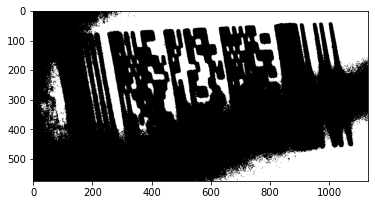

In [662]:
ret, thresh1 = cv2.threshold(input_image, 127, 255, cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap='gray')

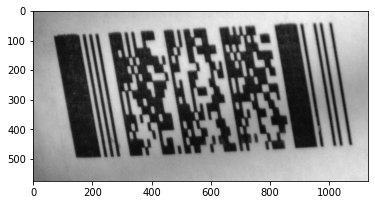

In [663]:
def convert_image(var_image):
    d = np.ndim(var_image)
    
    if d == 3:
        var_gray_img = cv2.cvtColor(var_image, cv2.COLOR_BGR2GRAY)
    else:
        var_gray_img = var_image
    
    return var_gray_img

converted_image = convert_image(input_image)
plt.imshow(converted_image, cmap='gray')

In [664]:
def all_corners(var_gray_img, threshold=0.12):

    corners = cv2.goodFeaturesToTrack(var_gray_img, 1000, threshold, 10)
    var_all_corners = np.array(tuple(map(np.ravel, corners)), dtype=np.int0)
    
    return var_all_corners

var_all_corners = all_corners(converted_image)
var_all_corners.shape

(516, 2)

In [665]:
def image_corners(var_gray_img):
    '''Find corner indices of the Image'''

    row, col = var_gray_img.shape
    img_area = row * col
    var_image_corners = [[0, 0],
                          [col - 1, 0],
                          [col - 1, row - 1],
                          [0, row - 1]]

    return var_image_corners

var_image_corners = image_corners(converted_image)
var_image_corners

[[0, 0], [1131, 0], [1131, 573], [0, 573]]

In [666]:
def min_dist(point, points_array):
    '''Find the min distance between reference points with the points'''
    
    x1, y1 = point
    dist_arr = []
    for i in range(len(points_array)):
        x2, y2 = points_array[i]
        d = mt.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        dist_arr.append(d)

    return min(dist_arr), np.argmin(dist_arr)


def distances(var_all_corners, var_image_corners):
    '''Find the distances of corners of the Barcode'''
    
    var_distances = [min_dist(point, var_all_corners) for point in var_image_corners]
    
    return var_distances


var_distances = distances(var_all_corners, var_image_corners)
var_distances

[(116.10340218959993, 316),
 (132.51792331605563, 49),
 (137.32079230764728, 116),
 (166.48123017325406, 395)]

In [667]:
def order_points(points):
    rect = np.zeros((4, 2), dtype="float32")

    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]
    rect[2] = points[np.argmax(s)]

    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]
    rect[3] = points[np.argmax(diff)]

    return rect

In [668]:
def barcode_corners(var_all_corners, var_distances):
    '''Get Barcode corner co-ordinates'''

    var_barcode_corners = order_points(np.array([var_all_corners[
                                                               var_distances[i][1]]
                                                           for i in range(4)]))
    return var_barcode_corners

var_barcode_corners = barcode_corners(var_all_corners, var_distances)
var_barcode_corners

array([[  78.,   86.],
       [1006.,   44.],
       [1072.,  449.],
       [ 146.,  493.]], dtype=float32)

In [669]:
def find_top_border_angle(var_barcode_corners):
    '''Find Angle of Top border'''
    
    P1 = var_barcode_corners[0][:]
    P2 = var_barcode_corners[1][:]

    top_line_angle = 90 - round(math.degrees(math.atan2((round(P1[0], 2) - 
                                                         round(P2[0], 2)), 
                                                        (round(P1[1], 2) - 
                                                         round(P2[1], 2)))))

    return top_line_angle

top_line_angle = find_top_border_angle(var_barcode_corners)
top_line_angle

177

In [670]:
def point_angles(var_barcode_corners):
    '''Get Barcode corner co-ordinates'''
    
    points = list(map(Point, var_barcode_corners))

    var_angle_arr = []
    for i in range(len(points)):
        l1 = Line(points[i], points[i - 1])
        try:
            l2 = Line(points[i], points[i + 1])
        except:
            l2 = Line(points[i], points[-len(points)])

        angle = l1.angle_between(l2)
        var_angle_arr.append(float(angle * (180 / pi)))
    
    return var_angle_arr

var_angle_arr = point_angles(var_barcode_corners)
var_angle_arr

[83.10621037603833, 96.66436815790595, 83.46470374403728, 96.76471772201845]

In [671]:
def associated_pts(var_angle_arr):

    var_associat_pts = []
    angle_variance = []
    angle_diff = []
    for i in range(len(var_angle_arr)):
        if i:
            angles = [var_angle_arr[i], var_angle_arr[i - 1]]
            var_associat_pts.append([i, angles])
        else:
            angles = [var_angle_arr[i], var_angle_arr[-1]]
            var_associat_pts.append([i, angles])
        angle_variance.append([i, np.var(angles)])
        angle_diff.append
        
    return var_associat_pts, angle_variance

var_associat_pts, angle_variance = associated_pts(var_angle_arr)
print(f'var_associat_pts: {var_associat_pts}')
print(f'angle_variance: {angle_variance}')

var_associat_pts: [[0, [83.10621037603833, 96.76471772201845]], [1, [96.66436815790595, 83.10621037603833]], [2, [83.46470374403728, 96.66436815790595]], [3, [96.76471772201845, 83.46470374403728]]]
angle_variance: [[0, 46.63870573004817], [1, 45.955910609504386], [2, 43.55778515968777], [3, 44.222592953623604]]


In [672]:
def vert_dist(var_barcode_corners, var_all_corners):

    p1, p2 = var_barcode_corners[:2]
    ppcular_dist = []
    for i in range(len(var_all_corners)):
        p3 = var_all_corners[i]
        d = abs(np.cross(p2 - p1, p3 - p1) / np.linalg.norm(p2 - p1))
        ppcular_dist.append(d)
    var_vert_dist = np.array(ppcular_dist)
    
    return var_vert_dist

var_vert_dist = vert_dist(var_barcode_corners, var_all_corners)
var_vert_dist.shape

(516,)

In [673]:
def sorted_distances(var_vert_dist):
    var_sorted_dist = np.sort(var_vert_dist)
    
    return var_sorted_dist

def distance_gradients(var_sorted_dist):
    var_dist_grad = np.gradient(var_sorted_dist)
    
    return var_dist_grad

def highest_peak(distance_gradients):
    var_highest_peak = np.max(distance_gradients)
    
    return var_highest_peak

def get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.5):

    peak_indices, peaks = find_peaks(var_dist_grad, height=height * var_highest_peak)
    peak_indices = np.append(peak_indices, len(var_sorted_dist))

    var_peak_indices, var_peaks = peak_indices, peaks['peak_heights']
    
    return var_peak_indices, var_peaks

var_sorted_dist = sorted_distances(var_vert_dist)
var_dist_grad = distance_gradients(var_sorted_dist)
var_highest_peak = highest_peak(var_dist_grad)

var_peak_indices, var_peaks = get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.7)
var_peak_indices

array([234, 516])

In [674]:
def search_threshold(converted_image, in_threshold_arr=[0.2, 0.25, 0.3, 0.35]):
    variance_data_arr = []
    peaks_data_arr = []
    out_threshold_arr = []
    
    present_flag = False

    for threshold in in_threshold_arr:

        try:
            # print(threshold_arr)
            print(threshold)
            var_all_corners = all_corners(converted_image, threshold=threshold)
            var_image_corners = image_corners(converted_image)
            var_distances = distances(var_all_corners, var_image_corners)
            var_barcode_corners = barcode_corners(var_all_corners, var_distances)
            top_line_angle = find_top_border_angle(var_barcode_corners)
            var_angle_arr = point_angles(var_barcode_corners)
            var_associat_pts, angle_variance = associated_pts(var_angle_arr)
            var_vert_dist = vert_dist(var_barcode_corners, var_all_corners)
            print(1)
            
            
            var_sorted_dist = sorted_distances(var_vert_dist)
            var_dist_grad = distance_gradients(var_sorted_dist)
            var_highest_peak = highest_peak(var_dist_grad)
            
            peak_indices, peaks = get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.4)
            print(2)
            variance_data = [np.var(peaks), np.var(np.gradient(peak_indices[:-1]))]
            print(f'peaks: {peak_indices}')
            print(f'len(peaks): {len(peaks)}')
            print(f'peaks_diff: {np.diff(np.array(sorted(peaks)))}')
            peaks_data_arr.append(peaks)
            variance_data_arr.append(variance_data)
            out_threshold_arr.append(threshold)
            present_flag = True
            
        except:
            pass

    if present_flag:
        variance_data_arr = np.transpose(variance_data_arr)
        peaks_data_arr = peaks_data_arr

    else:
        variance_data_arr = np.array([])
        peaks_data_arr = np.array([])
    
    return out_threshold_arr, peaks_data_arr, variance_data_arr

start = time.time()
threshold_arr, peaks_data_arr, variance_data_arr = search_threshold(converted_image)
print(f'Time Duration: {time.time() - start}')

print(f'threshold_arr: {threshold_arr}')
print(f'peaks_data_arr: {peaks_data_arr}')
print(f'variance_data_arr: {variance_data_arr}')

0.2
1
2
peaks: [ 17  30  48  67  85 105 125 139 154 171 186 206 222 237 250 270]
len(peaks): 15
peaks_diff: [0.68429499 0.53851786 0.57624841 0.58368019 0.92897189 0.14520545
 0.51679421 0.04516233 0.04516233 0.30413111 0.21552148 0.0663143
 0.24067518 0.251537  ]
0.25
1
2
peaks: [  6  15  26  40  55  68  82  91 104 114 125 137 150 162 171 185]
len(peaks): 15
peaks_diff: [2.11056534e+00 7.04317619e-02 1.42654162e-01 6.56567272e-02
 2.25023511e-01 1.21763385e-01 1.41460403e-01 1.19375868e-03
 1.76079405e-01 2.51286201e-01 4.64372125e-01 2.02938975e-01
 2.32782942e-01 4.35721917e-02]
0.3
1
2
peaks: [  5  11  19  29  37  46  55  63  72  81  90 100 104 115 117 122]
len(peaks): 15
peaks_diff: [5.48532112e-01 1.48026076e-01 1.19375868e-03 2.02342096e-01
 4.77503471e-02 3.75437104e-01 2.66208185e-01 2.02938975e-01
 2.38751735e-01 1.52801111e-01 3.84390294e-01 2.27411028e-01
 2.00133642e+00 9.65750769e-01]
0.35
1
2
peaks: [ 4  9 14 21 27 36 44 52 58 64 69 77 88 90 93]
len(peaks): 14
peaks_diff

In [675]:
def optim_threshold(threshold_arr, peaks_data, variance_data):
    var_optim_threshold = None
    save_var = {'variance': variance_data, 'peaks': peaks_data}
    
    good_heights = []
    if len(peaks_data):
        print(f'[max(peak) for peak in peaks_data]: {[max(peak) for peak in peaks_data]}')
        max_peak_list = [max(peak) for peak in peaks_data]
        
        sizes = []
        for max_peak, peaks_list in zip(max_peak_list, peaks_data):
            cap = 0.5 * max_peak

            print(f'max_peak: {max_peak}')
            print(f'peaks_list: {peaks_list}')
            mask = peaks_list  >= cap
            size = len(peaks_list)
            sizes.append(size)
        
            print(f'mask: {mask}')
            print(f'size: {size}')

            good_height = np.count_nonzero(mask) == size
            print(f'good_height: {good_height}')
            
            good_heights.append(good_height)

        order = variance_data.argsort()
        ranks = order.argsort()
        total_variance = np.var(ranks, axis=0)
        weighted_ranks = np.sum(ranks, axis=0)
        cum_ranks = np.sum([total_variance, weighted_ranks], axis=0)
        print(f'variance_data: {variance_data}')
        print(f'total_variance: {total_variance}')
        print(f'cum_ranks: {cum_ranks}')
        
        index = np.argmin(cum_ranks)
        
        print(f'good_heights: {good_heights}')
        print(f'index: {index}')

        indices = [i for i, j in enumerate(sizes) if j==max(sizes)]
#       index = sizes.index(max(sizes))
        print(f'indices: {indices}')

        good_indices = [index for index in indices if good_heights[index]]
        
        if len(good_indices):
            index = int(median(good_indices))
            var_optim_threshold = threshold_arr[index]
                
    print(f'var_optim_threshold: {var_optim_threshold}')
    return var_optim_threshold

start = time.time()
var_optim_threshold = optim_threshold(threshold_arr, peaks_data_arr, variance_data_arr)

print(f'Time taken: {time.time() - start}')
print(f'var_optim_threshold: {var_optim_threshold}')

[max(peak) for peak in peaks_data]: [9.073625767804486, 10.214992994026758, 13.909079218172593, 14.386582688735928]
max_peak: 9.073625767804486
peaks_list: [7.24312238 3.93140905 5.1542219  6.31415049 7.95028437 7.9954467
 9.07362577 7.90512205 5.73047031 8.2995778  8.51509928 8.58141358
 4.61570404 8.82208876 7.38832784]
mask: [ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True]
size: 15
good_height: False
max_peak: 10.214992994026758
peaks_list: [ 8.70130699  9.02004056  8.8427674   8.07577745 10.21499299  8.14620921
  9.93863786  8.57954361  8.84396115  8.3545201   9.73569889  9.27132676
  5.96521211 10.1714208   8.28886337]
mask: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
size: 15
good_height: True
max_peak: 13.909079218172593
peaks_list: [10.1773896  10.33019071  8.8427674  10.94199203 10.714581    8.14620921
  9.93863786  9.04630325  8.84396115  9.0940536   9.73569889 12.94332845
  9.4694907

In [676]:
def class_centers(var_peak_indices):
    '''To calculate centroids by averaging distance measures between peaks'''

    centroids = []
    for i in range(len(var_peak_indices)):
        if i == 0:
            min_idx = 0
            max_idx = var_peak_indices[i]
        elif i == len(var_peak_indices) - 1:
            min_idx = var_peak_indices[i - 1]
            max_idx = len(var_sorted_dist)
        else:
            min_idx = var_peak_indices[i - 1]
            max_idx = var_peak_indices[i]

        centroids.append(np.mean(var_sorted_dist[min_idx: max_idx]))

    return centroids


# var_all_corners = all_corners(converted_image, threshold=var_optim_threshold)
var_all_corners = all_corners(converted_image, threshold=THRESHOLD)
var_image_corners = image_corners(converted_image)
var_distances = distances(var_all_corners, var_image_corners)
var_barcode_corners = barcode_corners(var_all_corners, var_distances)
top_line_angle = find_top_border_angle(var_barcode_corners)
var_angle_arr = point_angles(var_barcode_corners)
var_associat_pts, angle_variance = associated_pts(var_angle_arr)
var_vert_dist = vert_dist(var_barcode_corners, var_all_corners)

var_sorted_dist = sorted_distances(var_vert_dist)
var_dist_grad = distance_gradients(var_sorted_dist)
var_highest_peak = highest_peak(var_dist_grad)

var_peak_indices, var_peaks = get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.51)
centroids = class_centers(var_peak_indices)
diff = np.diff(np.array(centroids)).tolist()
centroids

[2.12071228863954,
 24.845699332088234,
 53.36036169435968,
 80.71249689780227,
 111.54823283180751,
 140.57582797517793,
 166.68682623578215,
 194.79289842147162,
 220.13745624044566,
 250.44925717594032,
 274.45325896999617,
 306.3940810825705,
 333.96317248430194,
 360.70144610874917,
 388.851635256952,
 413.4510697535174]

In [677]:
def labels(var_vert_dist, var_sorted_dist, var_peak_indices):
    '''To get the labels of the co-ordinates with centroids as reference'''

    labels = copy.deepcopy(var_vert_dist)
    for i in range(len(var_peak_indices)):
        if i == 0:
            min_idx = 0
            max_idx = var_peak_indices[i]
        elif i == len(var_peak_indices) - 1:
            min_idx = var_peak_indices[i - 1]
            max_idx = len(var_sorted_dist) - 1
        else:
            min_idx = var_peak_indices[i - 1]
            max_idx = var_peak_indices[i]

        if i != len(var_peak_indices) - 1:
            labels[np.where((var_vert_dist < var_sorted_dist[max_idx]) &
                            (var_vert_dist >= var_sorted_dist[min_idx]))] = i
        else:
            labels[np.where((var_vert_dist <= var_sorted_dist[max_idx]) &
                            (var_vert_dist >= var_sorted_dist[min_idx]))] = i

    var_labels = labels.astype(int)
    
    return var_labels

var_labels = labels(var_vert_dist, var_sorted_dist, var_peak_indices)

var_labels1 = pd.Series(var_labels)
list(var_labels1.groupby(var_labels1).count())
np.var(var_labels1)

19.778056975894813

In [678]:
def center_coordinates(var_labels):
    '''Find the centroid of the coordinates'''

    var_center_coord = []
    concur_feat_sep = []
    coords = var_all_corners
    
    for i in range(len(np.unique(var_labels))):
        selected_bin = coords[np.where(var_labels == i)]
        centroid = np.mean(selected_bin, axis=0)
        var_center_coord.append(centroid)
        concur_feat_sep.append(centroid.astype('int'))
    
    return var_center_coord, concur_feat_sep


var_center_coord, int_var_center_coord = center_coordinates(var_labels)

print(f'\nvar_center_coord: {var_center_coord}\n')
print(f'\int_var_center_coord: {int_var_center_coord}\n')


var_center_coord: [array([469.16666667,  67.16666667]), array([576.        ,  86.33333333]), array([597.45454545, 114.        ]), array([517.        , 144.64285714]), array([555.66666667, 173.93333333]), array([509.84615385, 204.84615385]), array([539.21428571, 229.78571429]), array([523.44444444, 258.55555556]), array([618.07692308, 280.07692308]), array([625.8, 310.1]), array([537.09090909, 337.72727273]), array([550.08333333, 369.16666667]), array([587.69230769, 395.23076923]), array([601.83333333, 421.41666667]), array([610.88888889, 449.22222222]), array([689.64285714, 470.64285714])]

\int_var_center_coord: [array([469,  67]), array([576,  86]), array([597, 114]), array([517, 144]), array([555, 173]), array([509, 204]), array([539, 229]), array([523, 258]), array([618, 280]), array([625, 310]), array([537, 337]), array([550, 369]), array([587, 395]), array([601, 421]), array([610, 449]), array([689, 470])]



In [679]:
# def concurrent_feature_sep(var_center_coord, var_barcode_corners):

#     start = time.time()
#     (p1, p2) = var_barcode_corners[:2]
#     top_border = Line(Point(p1), Point(p2))
#     mid_point = Point(p1).midpoint(Point(p2))
#     ppcular_line = top_border.perpendicular_line(mid_point)
#     tap1 = time.time()
#     print(f'Time1: {tap1 - start}')
    
#     collect_feature_sep = []
#     for centroid in var_center_coord:
#         parallel_line = top_border.parallel_line(centroid)
#         feature_sep = ppcular_line.intersection(parallel_line)
#         collect_feature_sep.append(feature_sep[0])

#     var_concur_feat_sep = collect_feature_sep
#     print(f'Time2: {time.time() - tap1}')
    
#     return var_concur_feat_sep, ppcular_line

In [680]:
def concurrent_feature_sep(var_center_coord, var_barcode_corners):

    start = time.time()
    (p1, p2) = var_barcode_corners[:2]
    top_border = Line(Point(p1), Point(p2))
    mid_point = Point(p1).midpoint(Point(p2))
    ppcular_line = top_border.perpendicular_line(mid_point)
    tap1 = time.time()
    print(f'Time1: {tap1 - start}')
    a, b, c = ppcular_line.coefficients
    
    collect_feature_sep = []
    for centroid in var_center_coord:
        parallel_line = top_border.parallel_line(centroid)
        feature_sep = ppcular_line.intersection(parallel_line)
        collect_feature_sep.append(feature_sep[0])

    var_concur_feat_sep = collect_feature_sep
    print(f'Time2: {time.time() - tap1}')
    
    return var_concur_feat_sep

start = time.time()
var_concur_feat_sep = concurrent_feature_sep(var_center_coord, var_barcode_corners)
tap2 = time.time()
print(f'Time2: {tap2 - start}')

def get_coord_dist(var_concur_feat_sep):
    dist_arr = []
    for p1, p2 in zip(var_concur_feat_sep, var_concur_feat_sep[1:]):
        dist_arr.append(p1.distance(p2))
        
    return dist_arr

dist_arr = get_coord_dist(var_concur_feat_sep)
tap3 = time.time()
print(f'Time2: {tap3 - tap2}')
dist_arr

Time1: 0.010446786880493164
Time2: 0.3359851837158203
Time2: 0.34656834602355957
Time2: 0.0007963180541992188


[9837416666666661*sqrt(28069)/70172500000000000,
 2388645454545453*sqrt(28069)/14034500000000000,
 16038831818181829*sqrt(28069)/98241500000000000,
 180815566666664793*sqrt(28069)/982415000000000000,
 4863226666666747*sqrt(28069)/28069000000000000,
 1367058035714263*sqrt(28069)/8771562500000000,
 11772091269841563*sqrt(28069)/70172500000000000,
 4246177777777693*sqrt(28069)/28069000000000000,
 25391900000000067*sqrt(28069)/140345000000000000,
 20107918181818407*sqrt(28069)/140345000000000000,
 13378257575757597*sqrt(28069)/70172500000000000,
 5773589743589631*sqrt(28069)/35086250000000000,
 5599597756410369*sqrt(28069)/35086250000000000,
 23581138888888439*sqrt(28069)/140345000000000000,
 20606706349206407*sqrt(28069)/140345000000000000]

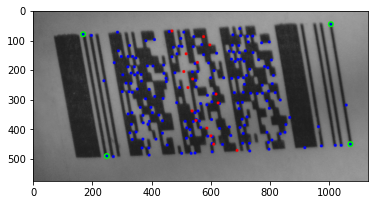

In [681]:
def overlay_corners(image, corners, radius, color, inplace=False):
    if not inplace:
        overlaid_image = copy.deepcopy(image)
    else:
        overlaid_image = image

    corners = tuple(map(tuple, corners))
    for corner in corners:
        cv2.circle(overlaid_image, corner, radius, color, -1)
    return overlaid_image


def overlay_lines(image, start, end, line_thickness, line_color, inplace=False):
    if not inplace:
        overlaid_image = copy.deepcopy(image)
    else:
        overlaid_image = image

    start, end = tuple(map(tuple, start)), tuple(map(tuple, end))
    for start_line, end_line in zip(start, end):
        cv2.line(overlaid_image, start_line, end_line, line_color, line_thickness)
    
    return overlaid_image

print()
debug_image = cv2.merge((input_image, input_image, input_image))
debug_image = overlay_corners(debug_image, var_barcode_corners, 10, (0, 255, 0), inplace=True)
debug_image = overlay_corners(debug_image, var_all_corners, 5, (0, 0, 255), inplace=True)
debug_image = overlay_corners(debug_image, int_var_center_coord, 5, (255, 0, 0), inplace=True)
plt.imshow(debug_image)

In [682]:
var_optim_threshold

0.25

In [683]:
def line_count(int_var_center_coord, req_line_cnt):

    line_count = req_line_cnt
    (p1, p2) = int_var_center_coord[:2]
    (x, y), (s, t) = p1, p2
    d8 = max(abs(x - s), abs(y - t))
#     print(f'd8: {d8}')
    
    if line_count > (d8 / 2.2):
        line_count = int(d8 / 2.2)
    else:
        line_count += 1
        
#     print(f'line_count: {line_count}')
    var_norm_distance = 1 / line_count
    var_line_count = line_count - 1
    
    return var_line_count, var_norm_distance

var_line_count, var_norm_distance = line_count(int_var_center_coord, 3)

print(f'var_line_count: {var_line_count}')
print(f'var_norm_distance: {var_norm_distance}')

var_line_count: 3
var_norm_distance: 0.25


In [684]:
def line_prof(var_image_corners, var_center_coord, top_line_angle):
    line_prof_coor_arr = []
    y_borderpoints = var_image_corners[-1]
    x_borderpoints = var_image_corners[1]
    
    print(f'y_borderpoints: {y_borderpoints}')
    print(f'x_borderpoints: {x_borderpoints}')
    
    max_line_length = 20000
    
    x_angle = math.cos(top_line_angle * pi / 180.0)
    y_angle = math.sin(top_line_angle * pi / 180.0)

    print(f'x_angle: {x_angle}')
    print(f'y_angle: {y_angle}')
    
    for i in range(len(var_center_coord)):
        P1x, P1y = var_center_coord[i][0], var_center_coord[i][1]
        P1x = int(P1x)
        P1y = int(P1y)            
        
        for j in range(max_line_length):
            P2x = int(round(P1x - j * x_angle))
            P2y = int(round(P1y - j * y_angle))
            
            if P2x in x_borderpoints or P2y in y_borderpoints:
                break
        
        for j in range(max_line_length):
            P3x = int(round(P1x + j * x_angle))
            P3y = int(round(P1y + j * y_angle))
            
            if P3x in x_borderpoints or P3y in y_borderpoints:
                break
                
            line_prof_coor_arr.append([(P3x, P3y), (P2x, P2y)])
    line_prof_coor_np_arr = np.asarray(line_prof_coor_arr)
    
    return line_prof_coor_np_arr

print(f'var_image_corners: {var_image_corners}')
print(f'top_line_angle: {top_line_angle}')
print(f'var_center_coord: {len(var_center_coord)}')

line_prof_coor_arr = line_prof(var_image_corners, var_center_coord, top_line_angle)
line_prof_coor_arr

var_image_corners: [[0, 0], [1131, 0], [1131, 573], [0, 573]]
top_line_angle: 178
var_center_coord: 16
y_borderpoints: [0, 573]
x_borderpoints: [1131, 0]
x_angle: -0.9993908270190958
y_angle: 0.0348994967025007


array([[[ 469,   67],
        [1131,   44]],

       [[ 468,   67],
        [1131,   44]],

       [[ 467,   67],
        [1131,   44]],

       ...,

       [[   3,  494],
        [1131,  455]],

       [[   2,  494],
        [1131,  455]],

       [[   1,  494],
        [1131,  455]]])

In [685]:
def row_extraction(var_gray_img, var_image_corners, top_line_angle, var_center_coord, req_line_cnt=3):

    # start_t = time.time()
    Int_prof_points = []
    req_line_cnt = req_line_cnt / 2
    y_borderpoints = var_image_corners[-1]
    x_borderpoints = var_image_corners[1]
    max_line_length = 20000
    x_angle = math.cos(top_line_angle * pi / 180.0)
    y_angle = math.sin(top_line_angle * pi / 180.0)
    int_prof = []
    dup_check = []

    for i in range(len(var_center_coord) - 1):

        start = int(var_center_coord[i][1])
        end = int(var_center_coord[i + 1][1])

        length = (end - start) / 2
        need_row = np.arange(length - math.floor(req_line_cnt), length + math.ceil(req_line_cnt))
        data_arr = []

        for k in need_row:
            P1x, P1y = var_center_coord[i][0], var_center_coord[i][1] + k
            P1x = int(P1x)
            P1y = int(P1y)
            right_line_prof = []
            for j in range(max_line_length):
                P2x = int(round(P1x - j * x_angle))
                P2y = int(round(P1y - j * y_angle))
                if P2x in x_borderpoints or P2y in y_borderpoints:
                    break
                if len(right_line_prof) >= 1:
                    if [P2y, P2x] != dup_check[-1]:
                        right_line_prof.append(var_gray_img[P2y, P2x])
                else:
                    right_line_prof.append(var_gray_img[P2y, P2x])
                dup_check = [[P2y, P2x]]

            left_line_prof = []
            for j in range(max_line_length):
                P3x = int(round(P1x + j * x_angle))
                P3y = int(round(P1y + j * y_angle))
                if P3x in x_borderpoints or P3y in y_borderpoints:
                    break
                if len(left_line_prof) >= 1:
                    if [P3y, P3x] != dup_check[-1]:
                        left_line_prof.append(var_gray_img[P3y, P3x])
                else:
                    left_line_prof.append(var_gray_img[P3y, P3x])
                dup_check = [[P3y, P3x]]
            Int_prof_points.append([(P3x, P3y), (P2x, P2y)])
            left_line_prof.reverse()
            data = left_line_prof + right_line_prof
            data_arr.append(data)

        int_prof.extend(data_arr)

    # print('Int_profile_time : ',time.time()-start_t)
    Int_prof_points = np.asarray(Int_prof_points)
    
    return int_prof, Int_prof_points

int_prof, Int_prof_points = row_extraction(converted_image, 
                                           var_image_corners, 
                                           top_line_angle, 
                                           var_center_coord, req_line_cnt=3)
np.array(int_prof).shape

(45, 1131)

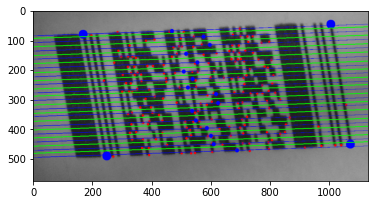

In [686]:
def debug_image(var_image, var_all_corners, var_barcode_corners, concur_feat_sep, line_prof_coor_arr):

    debug_img = copy.deepcopy(var_image)

    if not debug_img.ndim == 3:
        debug_img = np.stack((debug_img,) * 3, axis=-1)

    pt1_thickness, pt1_color = 4, (255, 0, 0)
    pt2_thickness, pt2_color = 15, (0, 0, 255)
    pt3_thickness, pt3_color = 7, (0, 0, 255)
    l1_thickness, l1_color = 1, (0, 0, 255)
    l2_thickness, l2_color = 1, (0, 255, 0)

    left_coord_arr = Int_prof_points[:, 0]
    right_coord_arr = Int_prof_points[:, 1]
    debug_img = overlay_corners(debug_img, var_all_corners, pt1_thickness, pt1_color)
    debug_img = overlay_corners(debug_img, var_barcode_corners, pt2_thickness, pt2_color)
    debug_img = overlay_corners(debug_img, concur_feat_sep, pt3_thickness, pt3_color)
    debug_img = overlay_lines(debug_img, line_prof_coor_arr[:, 0], line_prof_coor_arr[:, 1],
                                   l1_thickness, l1_color)
    debug_img = overlay_lines(debug_img, left_coord_arr, right_coord_arr, l2_thickness, l2_color)
    
    return debug_img


debug_image = debug_image(input_image, var_all_corners, var_barcode_corners, int_var_center_coord, line_prof_coor_arr)
plt.imshow(debug_image)

In [687]:
print(np.array(int_prof).shape, var_optim_threshold)

(45, 1131) 0.25


In [688]:
np.diff(np.array(list(map(int, dist_arr))[1:]))

array([-1,  3, -1, -3,  2, -3,  5, -6,  7, -4, -1,  2, -4])

In [689]:
def plot_int_profile(self):

    data = var_int_prof_arr
    fig_arr = []
    for i in range(len(data)):
        fig, ax = plt.subplots()
        for j in range(len(data[i])):
            elem_data = data[i][j]
            ax.plot(range(elem_data.shape[0]), elem_data, label='Line ' + str(j + 1))
        ax.legend()
        fig_arr.append(fig)
        
    return fig_arr

def plot_gradient(self):
    '''Visualization of height of each step'''

    x = np.arange(len(var_dist_grad))
    y = var_dist_grad
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(x, y)
    plt.title('Peaks Graph')
    
    return fig